<a href="https://colab.research.google.com/github/eagning1/DE1-G29/blob/main/DE1_G29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
#pip install nltk

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from collections import Counter, defaultdict
import re
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Download VADER lexicon if not already downloaded
try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\erkoo\AppData\Roaming\nltk_data...


In [6]:
# Set the style for our plots
plt.style.use('ggplot')
sns.set(font_scale=1.2)

In [12]:
class LyricsAnalyzer:
    def __init__(self, matches_file, train_file):
        """
        Initialize the LyricsAnalyzer with the paths to the dataset files.
        Parameters:
        -----------
        matches_file : str
            Path to the mxm_779k_matches.txt file
        train_file : str
            Path to the mxm_dataset_train.txt file
        """
        self.matches_file = matches_file
        self.train_file = train_file
        self.top_words = []
        self.matches_df = None
        self.lyrics_df = None
        self.word_counts = None
        self.sentiment_analyzer = SentimentIntensityAnalyzer()
        
    def load_matches(self):
        """Load and parse the matches file"""
        print("Loading matches data...")
        # Define column names based on the file format
        columns = ['msd_track_id', 'msd_artist_name', 'msd_title', 'mxm_track_id', 'mxm_artist_name', 'mxm_title']
        
        # Read the file
        data = []
        with open(self.matches_file, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('#'):  # Skip comment lines
                    continue
                parts = line.strip().split('<SEP>')
                if len(parts) == 6:  # Ensure we have all fields
                    data.append(parts)
        
        # Create DataFrame
        self.matches_df = pd.DataFrame(data, columns=columns)
        print(f"Loaded {len(self.matches_df)} song matches.")
        return self.matches_df
    
    def load_lyrics(self):
        """Load and parse the lyrics training file"""
        print("Loading lyrics data...")
        # First, extract the top words list
        self.top_words = []
        word_counts_data = []
        
        with open(self.train_file, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('#'):  # Skip comment lines
                    continue
                elif line.startswith('%'):  # Extract top words
                    self.top_words = line[1:].strip().split(',')
                else:
                    # Parse the word count line
                    parts = line.strip().split(',')
                    if len(parts) >= 2:
                        track_id = parts[0]
                        mxm_track_id = parts[1]
                        
                        # Create a sparse word count dictionary
                        word_counts = {}
                        for item in parts[2:]:
                            if ':' in item:
                                idx, count = item.split(':')
                                # Convert to 0-based index and ensure it's within range
                                word_idx = int(idx) - 1  # 1-based to 0-based
                                if word_idx < len(self.top_words):
                                    word_counts[self.top_words[word_idx]] = int(count)
                        
                        word_counts_data.append({
                            'track_id': track_id,
                            'mxm_track_id': mxm_track_id,
                            'word_counts': word_counts
                        })
        
        # Create DataFrame
        self.lyrics_df = pd.DataFrame(word_counts_data)
        print(f"Loaded lyrics data for {len(self.lyrics_df)} songs with {len(self.top_words)} vocabulary words.")
        return self.lyrics_df
    
    def merge_data(self):
        """Merge the matches and lyrics data"""
        if self.matches_df is None:
            self.load_matches()
        if self.lyrics_df is None:
            self.load_lyrics()
        
        # Merge on mxm_track_id
        merged_df = pd.merge(
            self.lyrics_df,
            self.matches_df,
            left_on='mxm_track_id',
            right_on='mxm_track_id',
            how='inner'
        )
        
        print(f"Merged data contains {len(merged_df)} songs.")
        return merged_df
    
    def create_word_count_matrix(self):
        """Convert sparse word counts to a matrix format"""
        if self.lyrics_df is None:
            self.load_lyrics()
        
        # Create a matrix where rows are songs and columns are words
        word_count_matrix = np.zeros((len(self.lyrics_df), len(self.top_words)))
        
        for i, row in enumerate(self.lyrics_df['word_counts']):
            for word, count in row.items():
                if word in self.top_words:
                    col_idx = self.top_words.index(word)
                    word_count_matrix[i, col_idx] = count
        
        self.word_counts = pd.DataFrame(word_count_matrix, columns=self.top_words)
        return self.word_counts
    
    def calculate_sentiment(self, merged_data=None):
        """Calculate sentiment scores for each song based on its word counts"""
        if merged_data is None:
            merged_data = self.merge_data()
        
        sentiment_scores = []
        
        for _, row in merged_data.iterrows():
            word_counts = row['word_counts']
            
            # Convert word counts to a pseudo-text for VADER
            # Repeat each word by its count to give it proper weight
            pseudo_text = ' '.join([f"{word} " * count for word, count in word_counts.items()])
            
            # Get sentiment scores
            sentiment = self.sentiment_analyzer.polarity_scores(pseudo_text)
            sentiment_scores.append({
                'track_id': row['track_id'],
                'artist': row['msd_artist_name'],
                'title': row['msd_title'],
                'negative': sentiment['neg'],
                'neutral': sentiment['neu'],
                'positive': sentiment['pos'],
                'compound': sentiment['compound']
            })
        
        sentiment_df = pd.DataFrame(sentiment_scores)
        return sentiment_df
    
    def cluster_songs(self, n_clusters=5):
        """Cluster songs based on their word usage patterns"""
        if self.word_counts is None:
            self.create_word_count_matrix()
        
        # Normalize word counts
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(self.word_counts)
        
        # Apply KMeans clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(scaled_features)
        
        # Add clusters to the original data
        clustered_data = self.lyrics_df.copy()
        clustered_data['cluster'] = clusters
        
        return clustered_data, kmeans
    
    def reduce_dimensions(self, method='pca', n_components=2):
        """Reduce dimensions of word count data for visualization"""
        if self.word_counts is None:
            self.create_word_count_matrix()
        
        # Normalize word counts
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(self.word_counts)
        
        if method.lower() == 'pca':
            reducer = PCA(n_components=n_components)
        elif method.lower() == 'tsne':
            reducer = TSNE(n_components=n_components, random_state=42)
        else:
            raise ValueError("Method must be either 'pca' or 'tsne'")
        
        reduced_features = reducer.fit_transform(scaled_features)
        
        return reduced_features
    
    def plot_most_common_words(self, top_n=20):
        """Plot the most common words across all songs"""
        if self.word_counts is None:
            self.create_word_count_matrix()
        
        # Sum word counts across all songs
        total_counts = self.word_counts.sum().sort_values(ascending=False)
        top_words = total_counts.head(top_n)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x=top_words.values, y=top_words.index)
        plt.title(f'Top {top_n} Most Common Words in Lyrics')
        plt.xlabel('Count')
        plt.ylabel('Word')
        plt.tight_layout()
        return plt
    
    def plot_sentiment_distribution(self, sentiment_df=None):
        """Plot the distribution of sentiment scores"""
        if sentiment_df is None:
            sentiment_df = self.calculate_sentiment()
        
        fig, axs = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot distributions of each sentiment score
        sns.histplot(sentiment_df['negative'], kde=True, ax=axs[0, 0], color='red')
        axs[0, 0].set_title('Negative Sentiment Distribution')
        
        sns.histplot(sentiment_df['neutral'], kde=True, ax=axs[0, 1], color='gray')
        axs[0, 1].set_title('Neutral Sentiment Distribution')
        
        sns.histplot(sentiment_df['positive'], kde=True, ax=axs[1, 0], color='green')
        axs[1, 0].set_title('Positive Sentiment Distribution')
        
        sns.histplot(sentiment_df['compound'], kde=True, ax=axs[1, 1], color='blue')
        axs[1, 1].set_title('Compound Sentiment Distribution')
        
        plt.tight_layout()
        return fig, axs
    
    def plot_cluster_visualization(self, clustered_data=None, kmeans=None, n_clusters=5):
        """Visualize song clusters in reduced dimensional space"""
        if clustered_data is None or kmeans is None:
            clustered_data, kmeans = self.cluster_songs(n_clusters)
        
        # Reduce to 2D for visualization
        reduced_features = self.reduce_dimensions(method='pca', n_components=2)
        
        # Plot
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(
            reduced_features[:, 0], 
            reduced_features[:, 1], 
            c=clustered_data['cluster'], 
            cmap='viridis', 
            alpha=0.5
        )
        
        # Plot cluster centers
        centers = kmeans.cluster_centers_
        if centers.shape[1] > 2:
            # Project cluster centers to the same 2D space
            pca = PCA(n_components=2)
            pca.fit(reduced_features)
            centers_2d = pca.transform(centers)
        else:
            centers_2d = centers
            
        plt.scatter(
            centers_2d[:, 0], 
            centers_2d[:, 1], 
            c='red', 
            marker='X', 
            s=200, 
            alpha=0.8
        )
        
        plt.colorbar(scatter, label='Cluster')
        plt.title('Song Clusters Visualization')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.tight_layout()
        return plt
    
    def analyze_artist(self, artist_name):
        """Analyze lyrics patterns for a specific artist"""
        merged_data = self.merge_data()
        
        # Filter for the artist
        artist_data = merged_data[merged_data['msd_artist_name'].str.lower() == artist_name.lower()]
        
        if len(artist_data) == 0:
            print(f"No data found for artist: {artist_name}")
            return None
        
        print(f"Analyzing {len(artist_data)} songs by {artist_name}")
        
        # Calculate sentiment for the artist's songs
        artist_sentiment = self.calculate_sentiment(artist_data)
        
        # Get most common words for this artist
        all_words = Counter()
        for word_counts in artist_data['word_counts']:
            all_words.update(word_counts)
        
        return {
            'artist_data': artist_data,
            'sentiment': artist_sentiment,
            'common_words': all_words
        }
    
    def compare_genres(self, genre_artist_mapping):
        """
        Compare lyrics and sentiment patterns across different genres
        
        Parameters:
        -----------
        genre_artist_mapping : dict
            Dictionary mapping genre names to lists of artists in that genre
        """
        merged_data = self.merge_data()
        genre_stats = {}
        
        for genre, artists in genre_artist_mapping.items():
            # Get data for all artists in this genre
            genre_data = merged_data[merged_data['msd_artist_name'].str.lower().isin([a.lower() for a in artists])]
            
            if len(genre_data) == 0:
                print(f"No data found for genre: {genre}")
                continue
                
            print(f"Analyzing {len(genre_data)} songs in the {genre} genre")
            
            # Calculate sentiment 
            genre_sentiment = self.calculate_sentiment(genre_data)
            
            # Get most common words for this genre
            genre_words = Counter()
            for word_counts in genre_data['word_counts']:
                genre_words.update(word_counts)
            
            genre_stats[genre] = {
                'data': genre_data,
                'sentiment': genre_sentiment,
                'common_words': genre_words
            }
        
        return genre_stats
    
    def plot_sentiment_by_genre(self, genre_stats):
        """Plot comparison of sentiment across genres"""
        if not genre_stats:
            return None
        
        # Prepare data for plotting
        genre_names = list(genre_stats.keys())
        sentiment_means = {
            'negative': [genre_stats[g]['sentiment']['negative'].mean() for g in genre_names],
            'neutral': [genre_stats[g]['sentiment']['neutral'].mean() for g in genre_names],
            'positive': [genre_stats[g]['sentiment']['positive'].mean() for g in genre_names],
            'compound': [genre_stats[g]['sentiment']['compound'].mean() for g in genre_names]
        }
        
        # Create bar plot
        fig, ax = plt.subplots(figsize=(12, 8))
        x = np.arange(len(genre_names))
        width = 0.2
        
        ax.bar(x - width*1.5, sentiment_means['negative'], width, label='Negative', color='red', alpha=0.7)
        ax.bar(x - width*0.5, sentiment_means['neutral'], width, label='Neutral', color='gray', alpha=0.7)
        ax.bar(x + width*0.5, sentiment_means['positive'], width, label='Positive', color='green', alpha=0.7)
        ax.bar(x + width*1.5, sentiment_means['compound'], width, label='Compound', color='blue', alpha=0.7)
        
        ax.set_xticks(x)
        ax.set_xticklabels(genre_names, rotation=45, ha='right')
        ax.set_ylabel('Mean Sentiment Score')
        ax.set_title('Sentiment Analysis by Genre')
        ax.legend()
        
        plt.tight_layout()
        return plt
    
    def run_full_analysis(self):
        """Run a complete analysis pipeline on the dataset"""
        # Load and merge data
        merged_data = self.merge_data()
        
        # Create word count matrix
        self.create_word_count_matrix()
        
        # Calculate sentiment
        sentiment_df = self.calculate_sentiment(merged_data)
        
        # Cluster songs
        clustered_data, kmeans = self.cluster_songs(n_clusters=5)
        
        # Generate plots
        plots = {
            'common_words': self.plot_most_common_words(top_n=20),
            'sentiment_distribution': self.plot_sentiment_distribution(sentiment_df)#,
            #'clusters': self.plot_cluster_visualization(clustered_data, kmeans)
        }
        
        return {
            'merged_data': merged_data,
            'sentiment': sentiment_df,
            'clusters': clustered_data,
            'plots': plots
        }

Loading matches data...
Loaded 779056 song matches.
Loading lyrics data...
Loaded lyrics data for 210519 songs with 5000 vocabulary words.
Merged data contains 265353 songs.


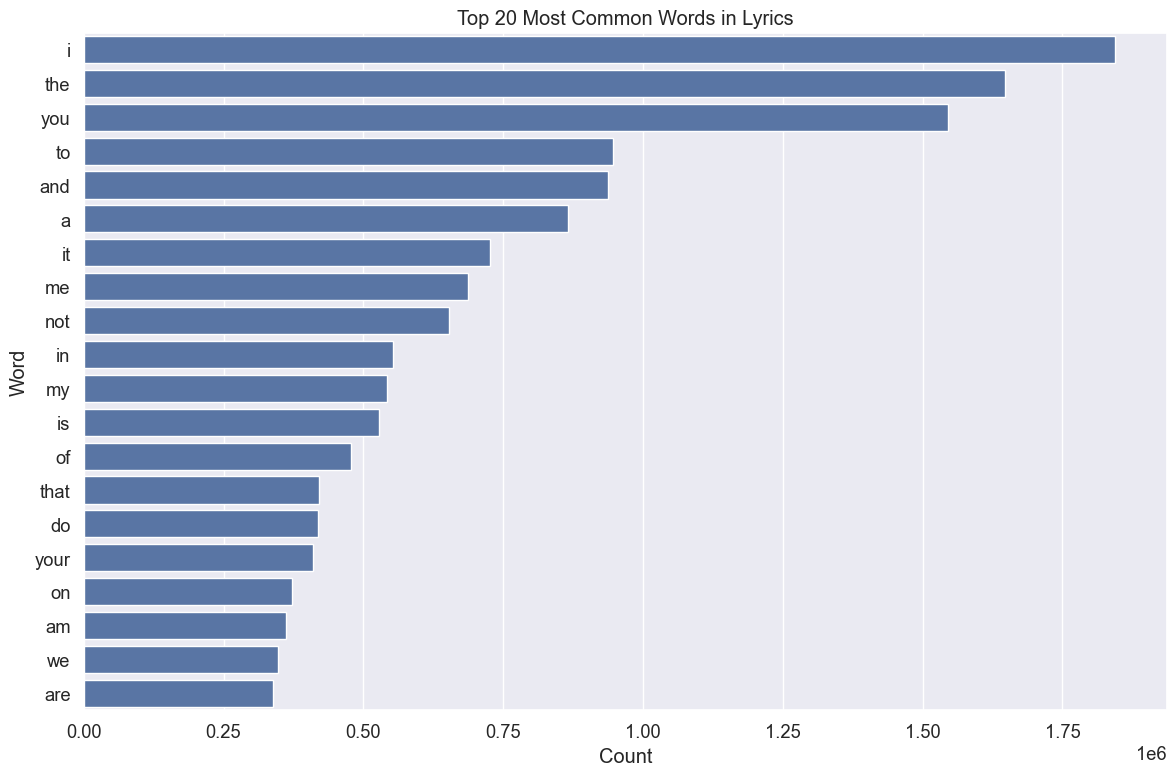

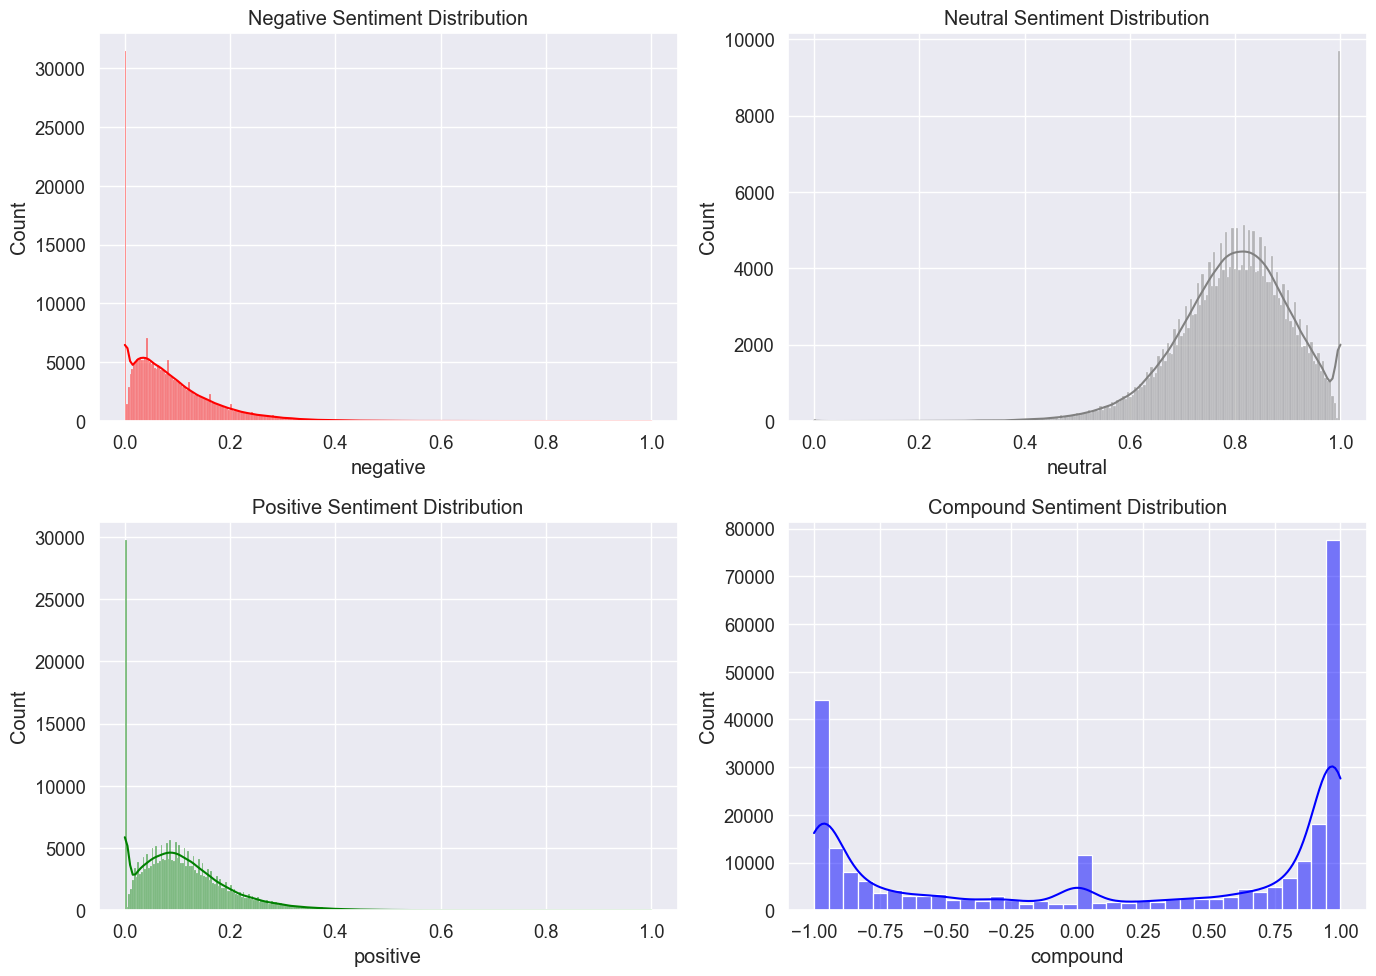

Merged data contains 265353 songs.
Analyzing 26 songs in the Rock genre
Analyzing 209 songs in the Pop genre
Analyzing 130 songs in the Rap genre


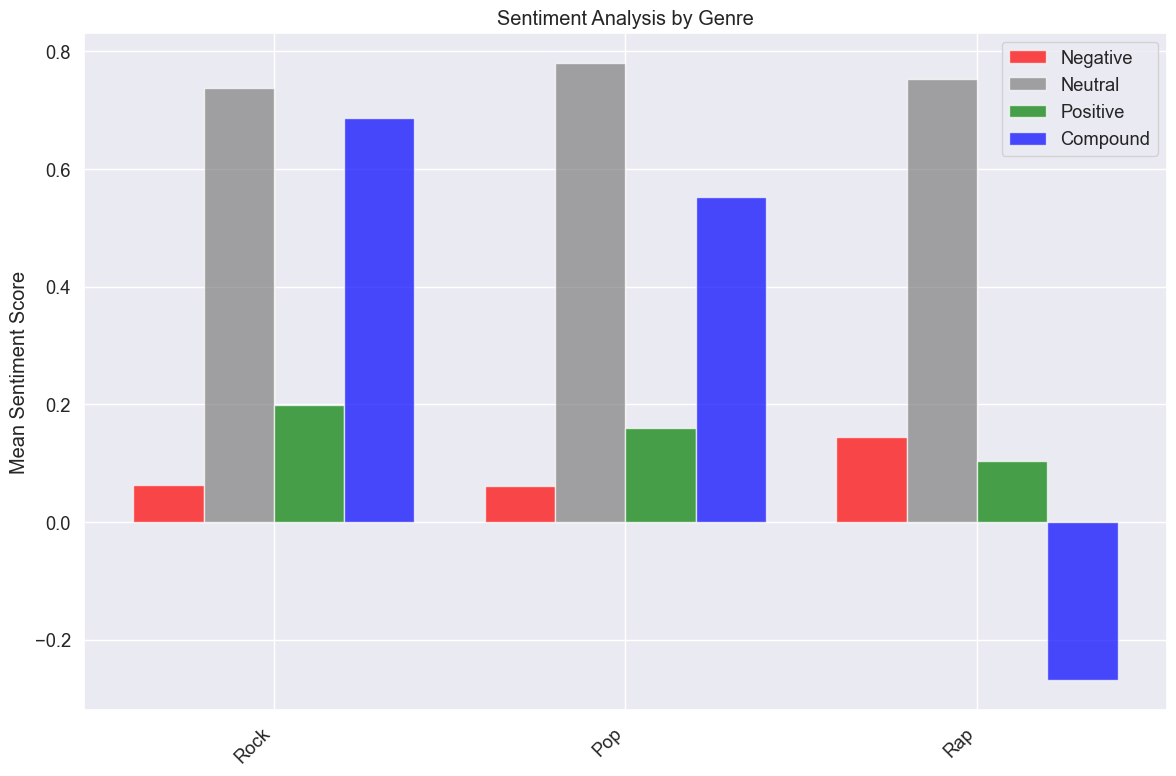

In [13]:
# Initialize the analyzer with file paths
analyzer = LyricsAnalyzer('mxm_779k_matches.txt', 'mxm_dataset_train.txt')

# Run the analysis
results = analyzer.run_full_analysis()

# Show plots
results['plots']['common_words'].show()
results['plots']['sentiment_distribution'][0].show()
#results['plots']['clusters'].show()

# Example of comparing genres
genre_mapping = {
    'Rock': ['Queen', 'The Beatles', 'Led Zeppelin', 'Pink Floyd', 'Rolling Stones'],
    'Pop': ['Michael Jackson', 'Madonna', 'Prince'],
    'Rap': ['Eminem', 'Jay-Z', 'Tupac']
}

genre_stats = analyzer.compare_genres(genre_mapping)
analyzer.plot_sentiment_by_genre(genre_stats).show()

In [14]:
results

{'merged_data':                   track_id mxm_track_id  \
 0       TRAAAAV128F421A322      4623710   
 1       TRAAABD128F429CF47      6477168   
 2       TRAAAED128E0783FAB      2516445   
 3       TRAAAEF128F4273421      3759847   
 4       TRAAAEW128F42930C0      3783760   
 ...                    ...          ...   
 265348  TRZZZWS128F429CF87      3080645   
 265349  TRZZZXA128F428ED56      2344272   
 265350  TRZZZXV128F4289747      1417347   
 265351  TRZZZYV128F92E996D      6849828   
 265352  TRZZZYX128F92D32C6       681124   
 
                                               word_counts        msd_track_id  \
 0       {'i': 6, 'the': 4, 'you': 2, 'to': 2, 'and': 5...  TRAAAAV128F421A322   
 1       {'i': 10, 'you': 17, 'to': 8, 'and': 2, 'a': 2...  TRAAABD128F429CF47   
 2       {'i': 28, 'the': 15, 'you': 2, 'to': 12, 'and'...  TRAAAED128E0783FAB   
 3       {'i': 5, 'the': 4, 'you': 3, 'to': 2, 'and': 1...  TRAAAEF128F4273421   
 4       {'i': 4, 'to': 5, 'and': 7, 'a': 2, 

In [17]:
results['merged_data']

,track_id,mxm_track_id,word_counts,msd_track_id,msd_artist_name,msd_title,mxm_artist_name,mxm_title
0,TRAAAAV128F421A322,4623710,"{'i': 6, 'the': 4, 'you': 2, 'to': 2, 'and': 5...",TRAAAAV128F421A322,Western Addiction,A Poor Recipe For Civic Cohesion,Western Addiction,A Poor Recipe for Civic Cohesion
1,TRAAABD128F429CF47,6477168,"{'i': 10, 'you': 17, 'to': 8, 'and': 2, 'a': 2...",TRAAABD128F429CF47,The Box Tops,Soul Deep,The Box Tops,Soul Deep
2,TRAAAED128E0783FAB,2516445,"{'i': 28, 'the': 15, 'you': 2, 'to': 12, 'and'...",TRAAAED128E0783FAB,Jamie Cullum,It's About Time,Jamie Cullum,It's About Time
3,TRAAAEF128F4273421,3759847,"{'i': 5, 'the': 4, 'you': 3, 'to': 2, 'and': 1...",TRAAAEF128F4273421,Adam Ant,Something Girls,Adam Ant,Something Girls
4,TRAAAEW128F42930C0,3783760,"{'i': 4, 'to': 5, 'and': 7, 'a': 2, 'me': 4, '...",TRAAAEW128F42930C0,Broken Spindles,Burn My Body (Album Version),Broken Spindles,Burn My Body
...,...,...,...,...,...,...,...,...
265348,TRZZZWS128F429CF87,3080645,"{'a': 1, 'no': 9, 'que': 7, 'de': 1, 'y': 4, '...",TRZZZWS128F429CF87,Los Prisioneros,Que No Destrocen Tu Vida,Los Prisioneros,Que no destrocen tu vida
265349,TRZZZXA128F428ED56,2344272,"{'i': 1, 'the': 13, 'you': 6, 'to': 5, 'and': ...",TRZZZXA128F428ED56,The God Awfuls,No Angels,The God Awfuls,No Angels
265350,TRZZZXV128F4289747,1417347,"{'i': 13, 'the': 3, 'you': 17, 'to': 5, 'and':...",TRZZZXV128F4289747,BlackHawk,Stepping Stones,Blackhawk,Stepping Stones
265351,TRZZZYV128F92E996D,6849828,"{'i': 10, 'the': 6, 'you': 20, 'and': 2, 'me':...",TRZZZYV128F92E996D,TLC,Dear Lie,TLC,Dear Lie


In [19]:
results['sentiment']

,track_id,artist,title,negative,neutral,positive,compound
0,TRAAAAV128F421A322,Western Addiction,A Poor Recipe For Civic Cohesion,0.081,0.769,0.151,0.7748
1,TRAAABD128F429CF47,The Box Tops,Soul Deep,0.018,0.876,0.105,0.9686
2,TRAAAED128E0783FAB,Jamie Cullum,It's About Time,0.029,0.831,0.140,0.9932
3,TRAAAEF128F4273421,Adam Ant,Something Girls,0.000,0.917,0.083,0.8689
4,TRAAAEW128F42930C0,Broken Spindles,Burn My Body (Album Version),0.134,0.835,0.031,-0.9100
...,...,...,...,...,...,...,...
265348,TRZZZWS128F429CF87,Los Prisioneros,Que No Destrocen Tu Vida,0.287,0.713,0.000,-0.9607
265349,TRZZZXA128F428ED56,The God Awfuls,No Angels,0.237,0.732,0.031,-0.9890
265350,TRZZZXV128F4289747,BlackHawk,Stepping Stones,0.104,0.783,0.112,0.2263
265351,TRZZZYV128F92E996D,TLC,Dear Lie,0.147,0.739,0.114,-0.9231


In [20]:
results['clusters']

,track_id,mxm_track_id,word_counts,cluster
0,TRAAAAV128F421A322,4623710,"{'i': 6, 'the': 4, 'you': 2, 'to': 2, 'and': 5...",2
1,TRAAABD128F429CF47,6477168,"{'i': 10, 'you': 17, 'to': 8, 'and': 2, 'a': 2...",2
2,TRAAAED128E0783FAB,2516445,"{'i': 28, 'the': 15, 'you': 2, 'to': 12, 'and'...",2
3,TRAAAEF128F4273421,3759847,"{'i': 5, 'the': 4, 'you': 3, 'to': 2, 'and': 1...",2
4,TRAAAEW128F42930C0,3783760,"{'i': 4, 'to': 5, 'and': 7, 'a': 2, 'me': 4, '...",2
...,...,...,...,...
210514,TRZZZWS128F429CF87,3080645,"{'a': 1, 'no': 9, 'que': 7, 'de': 1, 'y': 4, '...",2
210515,TRZZZXA128F428ED56,2344272,"{'i': 1, 'the': 13, 'you': 6, 'to': 5, 'and': ...",2
210516,TRZZZXV128F4289747,1417347,"{'i': 13, 'the': 3, 'you': 17, 'to': 5, 'and':...",2
210517,TRZZZYV128F92E996D,6849828,"{'i': 10, 'the': 6, 'you': 20, 'and': 2, 'me':...",2


# Problem description

# Workbook Setup

# Pre-processing

# Analysis